
Robot has fewer DOF (2) than the specified number of space dimensions to control (3). Poor performance may result.

Loading expression from joint0[0,0,0]_Tx ...
Loading expression from joint1[0,0,0]_Tx ...
Loading expression from EE[0,0,0]_Tx ...
Loading expression from EE[0,0,0]_J ...
Loading expression from M ...
Loading expression from g ...


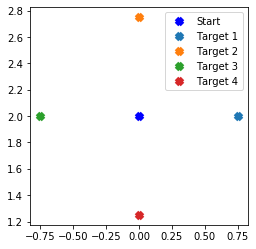

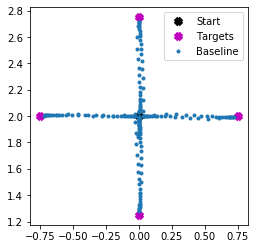

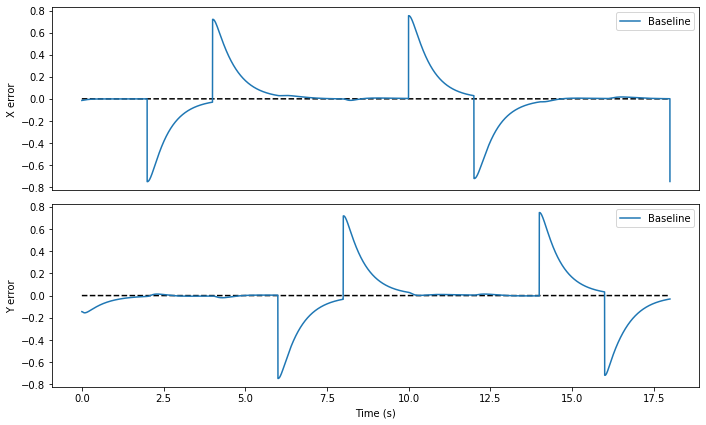

In [7]:
from abr_control.arms import twojoint as arm
from abr_control.controllers import OSC
import matplotlib.pyplot as plt
import nengo
import numpy as np

# set the initial position of the arm
robot_config = arm.Config(use_cython=True)
arm_sim = arm.ArmSim(
    robot_config=robot_config, dt=1e-3, q_init=[.95, 2.0])

# create an operational space controller
ctrlr = OSC(robot_config, kp=10, kv=7, vmax=[10, 10])

# create a set of targets to reach to
n_reaches = 4
distance = .75
center = [0, 2.0]
end_points = [[distance * np.cos(theta) + center[0],
               distance * np.sin(theta) + center[1]]
              for theta in np.linspace(0, 2*np.pi, n_reaches+1)][:-1]
targets = np.vstack([[center, ep] for ep in end_points])

plt.plot(center[0], center[1], 'bx', mew=5, label='Start')
for i, end_point in enumerate(end_points):
    plt.plot(end_point[0],
             end_point[1],
             'x',
             mew=5,
             label='Target %d' % (i + 1))
plt.gca().set_aspect('equal')
plt.legend()

def build_baseline_model():
    with nengo.Network(label="Nonlinear adaptive control") as model:

        # Create node that specifies target
        def gen_target(t):
            # Advance to the next target in the list every 2 seconds
            return targets[int(t / 2) % len(targets)]
        target_node = nengo.Node(output=gen_target, size_out=2)

        # Create node that calculates the OSC signal
        model.osc_node = nengo.Node(
            output=lambda t, x: ctrlr.generate(
                q=x[:2], dq=x[2:4], target=np.hstack([x[4:6], np.zeros(4)])),
            size_in=6, size_out=2)

        # Create node that runs the arm simulation and gets feedback
        def arm_func(t, x):
            u = x[:2]  # the OSC signal
            u += x[2:4] * 10  # add in the adaptive control signal
            arm_sim.send_forces(u)  # step the arm simulation forward
            # return arm joint angles, joint velocities, and hand (x,y)
            return np.hstack([arm_sim.q, arm_sim.dq, arm_sim.x])
        model.arm_node = nengo.Node(output=arm_func, size_in=4)

        # hook up the OSC controller and arm simulation
        nengo.Connection(model.osc_node, model.arm_node[:2])
        nengo.Connection(model.arm_node[:4], model.osc_node[:4])
        # send in current target to the controller
        nengo.Connection(target_node, model.osc_node[4:6])

        model.probe_target = nengo.Probe(target_node)  # track targets
        model.probe_hand = nengo.Probe(model.arm_node[4:6])  # track hand (x,y)
        model.probe_q = nengo.Probe(model.arm_node[:2])  # track joint angles

    return model


baseline_model = build_baseline_model()


# each reach is 2 seconds out + 2 seconds back in
runtime = n_reaches * 2 * 2 + 2

arm_sim.reset()
with nengo.Simulator(baseline_model, progress_bar=False) as sim:
    sim.run(runtime)
baseline_t = sim.trange()
baseline_data = sim.data

# error between point and target
def calculate_error(model, data):
    return data[model.probe_hand] - data[model.probe_target]


baseline_error = calculate_error(baseline_model, baseline_data)


def plot_data(t_set, data_set, label_set):
    plt.figure(figsize=(10, 6))
    plt.title("Distance to target")

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_set[0], np.zeros_like(t_set[0]), 'k--')
    plt.xticks([])
    plt.ylabel('X error')

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(t_set[0], np.zeros_like(t_set[0]), 'k--')
    plt.ylabel('Y error')
    plt.xlabel("Time (s)")

    plt.tight_layout()

    for t, data, label in zip(t_set, data_set, label_set):
        ax1.plot(t, data[:, 0], label=label)
        ax2.plot(t, data[:, 1], label=label)

    ax1.legend(loc=1)
    ax2.legend(loc=1)


def plot_xy(t_set, data_set, label_set):
    tspace = 0.1
    ttol = 1e-5

    plt.figure()
    ax = plt.subplot(111)
    ax.plot(center[0], center[1], 'kx', mew=5, label='Start')
    ax.plot([p[0] for p in end_points], [p[1] for p in end_points],
            'mx', mew=5, label='Targets')
    for t, data, label in zip(t_set, data_set, label_set):
        tmask = (t + ttol) % tspace < 2*ttol
        ax.plot(data[tmask, 0], data[tmask, 1], '.', label=label)
    ax.legend(loc=1)
    ax.set_aspect('equal')


plot_xy(
    [baseline_t],
    [baseline_data[baseline_model.probe_hand]],
    ['Baseline'])
plot_data(
    [baseline_t],
    [baseline_error],
    ['Baseline'])

In [6]:
baseline.model

NameError: name 'baseline' is not defined